In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
print("All file loaded")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

All file loaded


In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
from pathlib import Path

input_base_dir = "/kaggle/input/sea-animals-image-dataste"  # Adjust this to match your dataset path
output_base_dir = "/kaggle/working/"

# Function to enhance a single image
def enhance_image(image_path, output_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    # Step 1: Convert to LAB color space for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # Contrast Limited Adaptive Histogram Equalization
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    img_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    # Step 2: Reduce noise with Gaussian blur
    img_denoised = cv2.GaussianBlur(img_enhanced, (5, 5), 0)

    # Step 3: Simple color correction (white balance using gray world assumption)
    avg_b = np.mean(img_denoised[:, :, 0])  # Blue channel
    avg_g = np.mean(img_denoised[:, :, 1])  # Green channel
    avg_r = np.mean(img_denoised[:, :, 2])  # Red channel
    avg_gray = (avg_b + avg_g + avg_r) / 3

    # Scale each channel to balance colors
    img_denoised[:, :, 0] = np.clip(img_denoised[:, :, 0] * (avg_gray / avg_b), 0, 255)  # Blue
    img_denoised[:, :, 1] = np.clip(img_denoised[:, :, 1] * (avg_gray / avg_g), 0, 255)  # Green
    img_denoised[:, :, 2] = np.clip(img_denoised[:, :, 2] * (avg_gray / avg_r), 0, 255)  # Red

    # Save the enhanced image
    cv2.imwrite(output_path, img_denoised)

# Process all images in the dataset
for species_folder in os.listdir(input_base_dir):
    input_folder_path = os.path.join(input_base_dir, species_folder)
    output_folder_path = os.path.join(output_base_dir, species_folder)

    Path(output_folder_path).mkdir(parents=True, exist_ok=True)

    if os.path.isdir(input_folder_path):
        for image_file in os.listdir(input_folder_path):
            input_image_path = os.path.join(input_folder_path, image_file)
            output_image_path = os.path.join(output_folder_path, image_file)
            enhance_image(input_image_path, output_image_path)

print("Image enhancement completed!")

Image enhancement completed!


In [ ]:
import os
import random
import shutil

# Define paths
base_dir = "/kaggle/working/"  # Adjust if your train folder differs
turtle_dir = os.path.join(base_dir, "Turtle_Tortoise")

target_count = 500

turtle_files = [f for f in os.listdir(turtle_dir) if os.path.isfile(os.path.join(turtle_dir, f))]
current_count = len(turtle_files)
print(f"Current Turtle_Tortoise files: {current_count}")

# Calculate how many to remove
to_remove = max(0, current_count - target_count)
print(f"Files to remove: {to_remove}")

# Randomly select files to remove
if to_remove > 0:
    files_to_remove = random.sample(turtle_files, to_remove)
    
    # Remove files
    for file in files_to_remove:
        file_path = os.path.join(turtle_dir, file)
        os.remove(file_path)
    print("Files removed")

    # Verify new count
    new_count = len([f for f in os.listdir(turtle_dir) if os.path.isfile(os.path.join(turtle_dir, f))])
    print(f"New Turtle_Tortoise files: {new_count}")
else:
    print("No files need removal.")

Current Turtle_Tortoise files: 1903
Files to remove: 1403
Files removed
New Turtle_Tortoise files: 500


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Set random seed
tf.random.set_seed(42)

# Parameters
train_dir = "/kaggle/working/"
img_size = (224, 224)
batch_size = 64
num_classes = 23

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal")
])

# Apply augmentation and normalize
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True) / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:105]:  # Unfreeze last 50 layers (155 total layers)
    layer.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)  # Slightly higher to align train/val
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, mode='min')


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,  
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate with clean datasets (no augmentation interference)
train_dataset_eval = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
).map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.AUTOTUNE)

val_dataset_eval = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
).map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.AUTOTUNE)

train_loss, train_acc = model.evaluate(train_dataset_eval)
val_loss, val_acc = model.evaluate(val_dataset_eval)
print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")
 
model.save("/kaggle/working/marine_species_model_90_perfect.h5")
print("Model saved successfully!")

Found 12308 files belonging to 23 classes.
Using 9847 files for training.
Found 12308 files belonging to 23 classes.
Using 2461 files for validation.
Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 87s 451ms/step - accuracy: 0.3229 - loss: 2.3475 - val_accuracy: 0.4145 - val_loss: 3.0480 - learning_rate: 5.0000e-04
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 63s 399ms/step - accuracy: 0.5581 - loss: 1.4857 - val_accuracy: 0.4527 - val_loss: 2.5494 - learning_rate: 5.0000e-04
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 62s 396ms/step - accuracy: 0.6159 - loss: 1.2931 - val_accuracy: 0.4002 - val_loss: 4.5001 - learning_rate: 5.0000e-04
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 62s 397ms/step - accuracy: 0.6614 - loss: 1.1562 - val_accuracy: 0.5205 - val_loss: 2.6490 - learning_rate: 5.0000e-04
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 62s 394ms/step - accuracy: 0.7053 - loss: 0.9706 - val_accuracy: 0.7168 - val_loss: 1.2937 - learning_rate: 1.0000e-04
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 62s 393ms/step 

In [ ]:
import shutil

#shutil.rmtree('/kaggle/working/.virtual_documents', ignore_errors=True)


Model loaded successfully from: /kaggle/working/marine_species_model_90_perfect.h5
Found 10 images in /kaggle/input/testing
Predicting species for all images in testing folder:


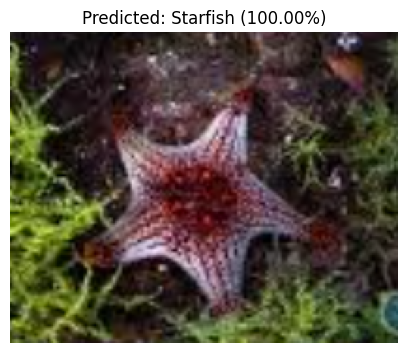

Image: /kaggle/input/testing/Screenshot 2025-03-23 002204.png
Predicted: Starfish (100.00%)



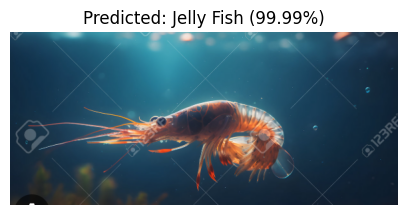

Image: /kaggle/input/testing/Screenshot 2025-03-23 001917.png
Predicted: Jelly Fish (99.99%)



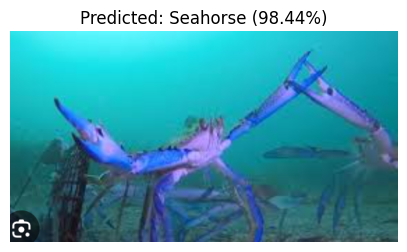

Image: /kaggle/input/testing/Screenshot 2025-03-23 002338.png
Predicted: Seahorse (98.44%)



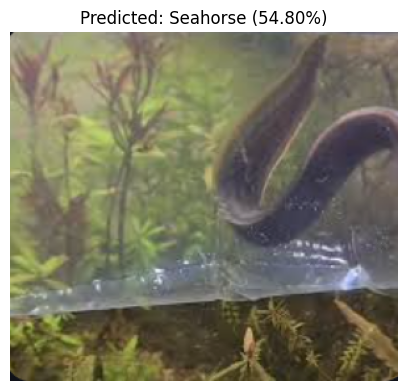

Image: /kaggle/input/testing/Screenshot 2025-03-23 000352.png
Predicted: Seahorse (54.80%)



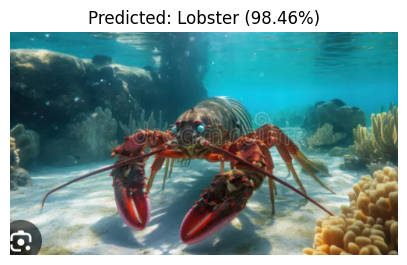

Image: /kaggle/input/testing/Screenshot 2025-03-23 002114.png
Predicted: Lobster (98.46%)



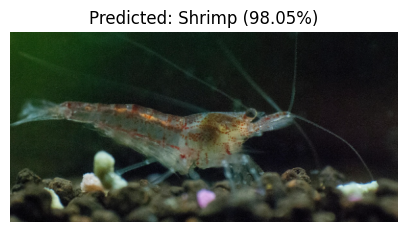

Image: /kaggle/input/testing/Screenshot 2025-03-23 002015.png
Predicted: Shrimp (98.05%)



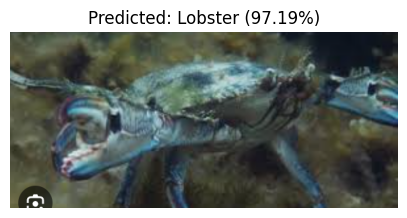

Image: /kaggle/input/testing/Screenshot 2025-03-23 002401.png
Predicted: Lobster (97.19%)



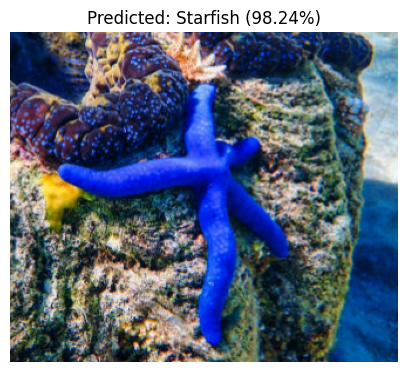

Image: /kaggle/input/testing/Screenshot 2025-03-23 002307.png
Predicted: Starfish (98.24%)



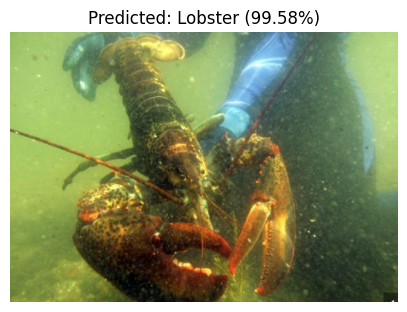

Image: /kaggle/input/testing/Screenshot 2025-03-23 002055.png
Predicted: Lobster (99.58%)



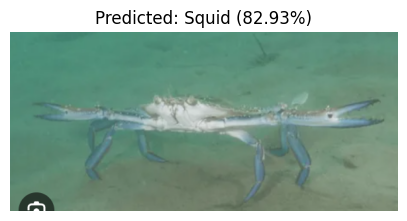

Image: /kaggle/input/testing/Screenshot 2025-03-23 002351.png
Predicted: Squid (82.93%)



In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define parameters
model_path = '/kaggle/working/marine_species_model_90_perfect.h5'
input_size = (224, 224)
class_labels = ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 
                'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 
                'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']

# Load the model
model = load_model(model_path)
print("Model loaded successfully from:", model_path)

# Preprocess image
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(input_size)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Predict and display
def predict_image(image_path):
    img_array = preprocess_image(image_path)
    if img_array is None:
        return None, None
    
    preds = model.predict(img_array, verbose=0)[0]
    pred_class_idx = np.argmax(preds)
    pred_class = class_labels[pred_class_idx]
    confidence = preds[pred_class_idx] * 100
    
    # Display image with prediction
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return pred_class, confidence

# Define testing folder path
testing_folder = '/kaggle/input/testing'  # Adjust if it's in /kaggle/input/testing/

# Get all image paths
image_paths = [os.path.join(testing_folder, f) for f in os.listdir(testing_folder) 
               if os.path.isfile(os.path.join(testing_folder, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(image_paths)} images in {testing_folder}")

# Predict for each image
print("Predicting species for all images in testing folder:")
for image_path in image_paths:
    pred_class, confidence = predict_image(image_path)
    if pred_class:
        print(f"Image: {image_path}")
        print(f"Predicted: {pred_class} ({confidence:.2f}%)\n")
    else:
        print(f"Skipped: {image_path} (failed to process)\n")